In [1]:
import pandas as pd
import numpy as np
import missingno
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from imblearn.over_sampling import ADASYN
import warnings

In [2]:
df = pd.read_excel('harmony.xlsx', na_values="noNote")
df.head()

,chord,file,keySignature,note1,note2,note3,note4,note5,note6,note7,note8,note9,note10
0,C,a Chord Chart for Jazz-10.semantic,CM,note-C4,note-E4,note-G4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F,a Chord Chart for Jazz-10.semantic,CM,note-F4,note-A4,note-C5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bb,a Chord Chart for Jazz-10.semantic,CM,note-Bb3,note-D4,note-F4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Eb,a Chord Chart for Jazz-10.semantic,CM,note-Eb4,note-G4,note-Bb4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ab,a Chord Chart for Jazz-10.semantic,CM,note-Ab3,note-Cb4,note-Eb4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# remove irrelevant column
df.drop(['file'], axis=1, inplace=True)
df.head()

,chord,keySignature,note1,note2,note3,note4,note5,note6,note7,note8,note9,note10
0,C,CM,note-C4,note-E4,note-G4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F,CM,note-F4,note-A4,note-C5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bb,CM,note-Bb3,note-D4,note-F4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Eb,CM,note-Eb4,note-G4,note-Bb4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ab,CM,note-Ab3,note-Cb4,note-Eb4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

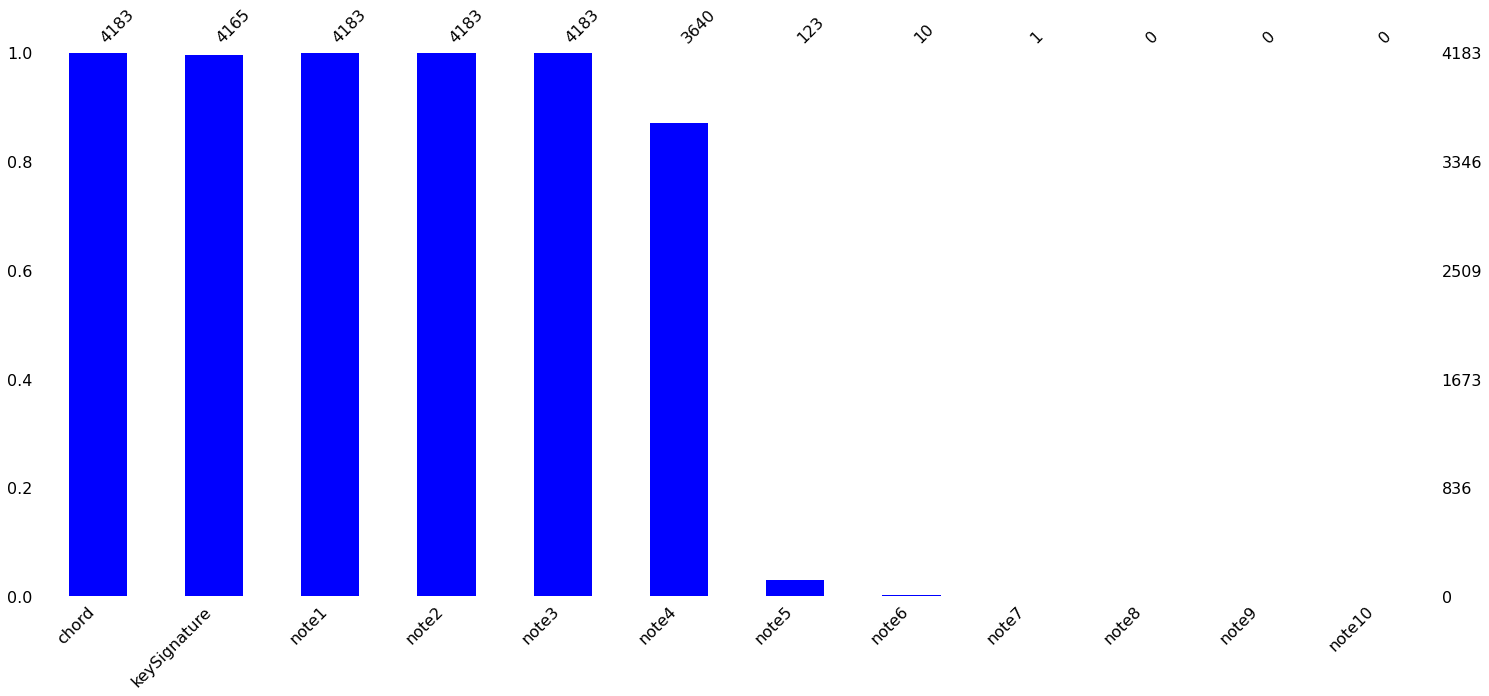

In [4]:
# check missing values
missingno.bar(df, color='blue')

In [5]:
# remove no data column
df.drop(['note7','note8','note9','note10'], axis=1, inplace=True)
df.head()

,chord,keySignature,note1,note2,note3,note4,note5,note6
0,C,CM,note-C4,note-E4,note-G4,NaN,NaN,NaN
1,F,CM,note-F4,note-A4,note-C5,NaN,NaN,NaN
2,Bb,CM,note-Bb3,note-D4,note-F4,NaN,NaN,NaN
3,Eb,CM,note-Eb4,note-G4,note-Bb4,NaN,NaN,NaN
4,Ab,CM,note-Ab3,note-Cb4,note-Eb4,NaN,NaN,NaN


In [6]:
chord = df['chord'].value_counts()
chord

Dm7            154
Am7            110
Gm7             93
Bb13            68
F               67
              ... 
C7(#5#9)         1
C13(sus4b9)      1
C/G              1
BbΔ9             1
F#m9             1
Name: chord, Length: 402, dtype: int64

In [7]:
# modify keys' names
for n in range(len(df)):
    key = df['keySignature'][n]
    if isinstance(key,str):
        key = key.strip()
        df['keySignature'][n] = key

In [8]:
# Slash Chords & Extension & Alteration
for n in range(len(df)):
    chord = df['chord'][n]
    if '/' in chord:
        chord = chord.split('/')[0]
        df['chord'][n] = chord
    if 'omit' in chord:
        chord = chord.replace('omit','o')
        df['chord'][n] = chord
    if 'mi' in chord:
        chord = chord.replace('mi','m')
        df['chord'][n] = chord
    if '(' in chord:
        chord = chord.split('(')[0]
        df['chord'][n] = chord
    if '69' in chord:
        chord = chord.replace('69','7')
        df['chord'][n] = chord
    # if 'b5' in chord:
    #     chord = chord.replace('b5','b7')
    #     df['chord'][n] = chord
    # if '#9' in chord:
    #     chord = chord.replace('#9','#7')
    #     df['chord'][n] = chord
    # if '#5' in chord:
    #     chord = chord.replace('#5','#7')
    #     df['chord'][n] = chord
    # if 'b9' in chord:
    #     chord = chord.replace('b9','b7')
    #     df['chord'][n] = chord
    if '13' in chord:
        chord = chord.replace('13','7')
        df['chord'][n] = chord
    if '9' in chord:
        chord = chord.replace('9','7')
        df['chord'][n] = chord
    if '11' in chord:
        chord = chord.replace('11','7')
        df['chord'][n] = chord

In [9]:
chord = df['chord'].value_counts()
chord

C7       231
Dm7      219
Gm7      181
G7       170
Am7      163
        ... 
Cm7#5      1
Gsus4      1
D#7        1
D#7#7      1
Am7b5      1
Name: chord, Length: 216, dtype: int64

In [10]:
# frequency check
delete = []
for i in range(len(df['chord'])):
    frequency = chord[df['chord'][i]]
    if frequency <= 25:
        delete.append(i)
        
df.drop(delete, axis=0, inplace=True)
df = df.reset_index()
df.drop('index', axis=1, inplace=True)
df.head()

,chord,keySignature,note1,note2,note3,note4,note5,note6
0,C,CM,note-C4,note-E4,note-G4,NaN,NaN,NaN
1,F,CM,note-F4,note-A4,note-C5,NaN,NaN,NaN
2,Bb,CM,note-Bb3,note-D4,note-F4,NaN,NaN,NaN
3,Eb,CM,note-Eb4,note-G4,note-Bb4,NaN,NaN,NaN
4,Ab,CM,note-Ab3,note-Cb4,note-Eb4,NaN,NaN,NaN


In [11]:
chord = df['chord'].value_counts()
chord

C7      231
Dm7     219
Gm7     181
G7      170
Am7     163
Bb7     156
F7      145
D7      145
Eb7     125
Cm7     116
Ab7     103
A7       97
Db7      89
Bbm7     80
E7       79
Em7      74
Fm7      70
F        68
C        66
Bm7      58
G        56
B7       51
C6       49
F6       47
Eb       46
Eo7      45
Bb       38
Ebm7     38
A7#5     37
D7b7     36
Ab       33
G7b7     30
Db       29
G6       29
Ao7      28
Bo7      27
Name: chord, dtype: int64

In [12]:
delete = set()
for i in range(1,7):
    category = 'note' + str(i)
    for n in range(len(df)):
        note = df[category][n]
        
        if isinstance(note,str):
            if "note" not in note:
                # delete.add(n)
                df[category][n] = np.NAN

In [13]:
delete = list(delete)
delete

[]

In [14]:
df.drop(delete, axis=0, inplace=True)
df = df.reset_index()
df.drop('index', axis=1, inplace=True)
df.head()

,chord,keySignature,note1,note2,note3,note4,note5,note6
0,C,CM,note-C4,note-E4,note-G4,NaN,NaN,NaN
1,F,CM,note-F4,note-A4,note-C5,NaN,NaN,NaN
2,Bb,CM,note-Bb3,note-D4,note-F4,NaN,NaN,NaN
3,Eb,CM,note-Eb4,note-G4,note-Bb4,NaN,NaN,NaN
4,Ab,CM,note-Ab3,note-Cb4,note-Eb4,NaN,NaN,NaN


In [15]:
# change note based on keys
delete = set()
# key signature
for i in range(len(df)):
    mykey = df['keySignature'][i]
    
    if not isinstance(mykey,str):
        delete.add(i)
    else:
        pass
#         for n in range(1,7):
#             category = 'note' + str(n)
#             note = df[category][n]
#             if isinstance(note,str):
#                 # no flats or sharps - natural symbol?
#                 note = note.replace('#','')
#                 note = note.replace('b','')
#                 if mykey == 'CM':
#                     df[category][n] = note

#                 elif mykey == 'EM':
#                     # E, F♯, G♯, A, B, C♯, and D♯
#                     if 'F' in note:
#                         note = note.replace('F','F#')
#                     if 'G' in note:
#                         note = note.replace('G','G#')
#                     if 'C' in note:
#                         note = note.replace('C','C#')
#                     if 'D' in note:
#                         note = note.replace('D','D#')
#                     df[category][n] = note

#                 elif mykey == 'GM':
#                     # G, A, B, C, D, E, and F♯
#                     if 'F' in note:
#                         note = note.replace('F','F#')
#                     df[category][n] = note

#                 elif mykey == 'AM':
#                     # A, B, C♯, D, E, F♯, and G♯
#                     if 'C' in note:
#                         note = note.replace('C','C#')
#                     if 'F' in note:
#                         note = note.replace('F','F#')
#                     if 'G' in note:
#                         note = note.replace('G','G#')
#                     df[category][n] = note

#                 elif mykey == 'BM':
#                     # B, C♯, D♯, E, F♯, G♯, and A♯
#                     if 'C' in note:
#                         note = note.replace('C','C#')
#                     if 'D' in note:
#                         note = note.replace('D','D#')
#                     if 'F' in note:
#                         note = note.replace('F','F#')
#                     if 'G' in note:
#                         note = note.replace('G','G#')
#                     if 'A' in note:
#                         note = note.replace('A','A#')
#                     df[category][n] = note

#                 elif mykey == 'DM':
#                     # D, E, F♯, G, A, B, and C♯
#                     if 'C' in note:
#                         note = note.replace('C','C#')
#                     if 'F' in note:
#                         note = note.replace('F','F#')
#                     df[category][n] = note

#                 elif mykey == 'FM':
#                     # F, G, A, B♭, C, D, and E
#                     if 'B' in note:
#                         note = note.replace('B','Bb')
#                     df[category][n] = note

#                 elif mykey == 'AbM':
#                     # A♭, B♭, C, D♭, E♭, F, and G
#                     if 'A' in note:
#                         note = note.replace('A','Ab')
#                     if 'B' in note:
#                         note = note.replace('B','Bb')
#                     if 'D' in note:
#                         note = note.replace('D','Db')
#                     if 'E' in note:
#                         note = note.replace('E','Eb')
#                     df[category][n] = note

#                 elif mykey == 'BbM':
#                     # B♭, C, D, E♭, F, G, and A
#                     if 'B' in note:
#                         note = note.replace('B','Bb')
#                     if 'E' in note:
#                         note = note.replace('E','Eb')
#                     df[category][n] = note

#                 elif mykey == 'DbM':
#                     #  D♭, E♭, F, G♭, A♭, B♭ and C
#                     if 'D' in note:
#                         note = note.replace('D','Db')
#                     if 'E' in note:
#                         note = note.replace('E','Eb')
#                     if 'G' in note:
#                         note = note.replace('G','Gb')
#                     if 'A' in note:
#                         note = note.replace('A','Ab')
#                     if 'B' in note:
#                         note = note.replace('B','Bb')
#                     df[category][n] = note

#                 elif mykey == 'EbM':
#                     # E♭, F, G, A♭, B♭, C, and D
#                     if 'E' in note:
#                         note = note.replace('E','Eb')
#                     if 'A' in note:
#                         note = note.replace('A','Ab')
#                     if 'B' in note:
#                         note = note.replace('B','Bb')
#                     df[category][n] = note
warnings.filterwarnings("ignore")

In [16]:
delete = list(delete)
delete

[1911,
 1906,
 1907,
 1908,
 1459,
 1460,
 1909,
 1910,
 1912,
 1914,
 1915,
 1916,
 1917,
 1913]

In [17]:
# handle empty keys
df.drop(delete, axis=0, inplace=True)
df = df.reset_index()
df.drop('index', axis=1, inplace=True)
df.head()

,chord,keySignature,note1,note2,note3,note4,note5,note6
0,C,CM,note-C4,note-E4,note-G4,NaN,NaN,NaN
1,F,CM,note-F4,note-A4,note-C5,NaN,NaN,NaN
2,Bb,CM,note-Bb3,note-D4,note-F4,NaN,NaN,NaN
3,Eb,CM,note-Eb4,note-G4,note-Bb4,NaN,NaN,NaN
4,Ab,CM,note-Ab3,note-Cb4,note-Eb4,NaN,NaN,NaN


In [18]:
# note encoding rule
def changeNote(o):
    dict = {
        'C': 1,
        'D': 2,
        'E': 3,
        'F': 4,
        'G': 5,
        'A': 6,
        'B': 7}
    return dict.get(o)

In [19]:
scaler = 1

In [20]:
# encoding for notes
delete = set()
for i in range(1,7):
    category = 'note' + str(i)
    for n in range(len(df)):
        note = df[category][n]
        
        if isinstance(note,str):
            if "note" not in note:
                delete.add(n)
                
            else:
                myNote = note.split("-")[1]
                if len(myNote) == 2:
                    num = changeNote(myNote[0])*scaler
                    df[category][n] = num*scaler + 7*(int(myNote[1])-1)*scaler
                if len(myNote) == 3:
                    num1 = changeNote(myNote[0])
                    if myNote[1] == 'b':
                        num2 = -0.49
                    else:
                        num2 = 0.49
                    df[category][n] = num1*scaler + 7*(int(myNote[2])-1)*scaler + num2*scaler

In [21]:
delete = list(delete)
delete

[]

In [22]:
df.drop(delete, axis=0, inplace=True)
df = df.reset_index()
df.drop('index', axis=1, inplace=True)
df.head()

,chord,keySignature,note1,note2,note3,note4,note5,note6
0,C,CM,22,24,26,NaN,NaN,NaN
1,F,CM,25,27,29,NaN,NaN,NaN
2,Bb,CM,20.51,23,25,NaN,NaN,NaN
3,Eb,CM,23.51,26,27.51,NaN,NaN,NaN
4,Ab,CM,19.51,21.51,23.51,NaN,NaN,NaN


In [23]:
# label encoding for kyes and chords
le1 = LabelEncoder()
encoder_chord = le1.fit(df['chord'])
df['chord'] = encoder_chord.transform(df['chord'])
joblib.dump(le1, 'chord.pkl')

le2 = LabelEncoder()
encoder_key = le2.fit(df['keySignature'])
df['keySignature'] = encoder_key.transform(df['keySignature'])
joblib.dump(le2, 'key.pkl')

['key.pkl']

In [24]:
le1.inverse_transform([0])

array(['A7'], dtype=object)

In [25]:
le2.inverse_transform([0])

array(['AM'], dtype=object)

In [26]:
# df.drop('keySignature', axis=1, inplace=True)
# df.head()

In [27]:
# KNN imputation
imputer = KNNImputer(n_neighbors=3)
imputed = imputer.fit_transform(df)
df = pd.DataFrame(imputed, columns=df.columns)
joblib.dump(imputer, 'KNN.pkl')
df.head()

,chord,keySignature,note1,note2,note3,note4,note5,note6
0,12.0,3.0,22.00,24.00,26.00,29.333333,30.000000,32.000000
1,27.0,3.0,25.00,27.00,29.00,31.006667,29.170000,32.000000
2,7.0,3.0,20.51,23.00,25.00,27.170000,29.333333,29.666667
3,22.0,3.0,23.51,26.00,27.51,30.006667,29.836667,32.000000
4,2.0,3.0,19.51,21.51,23.51,27.006667,26.666667,29.666667


In [28]:
# np.any(pd.isnull((df['keySignature'])))

In [29]:
# means = [df['note1'].mean(),df['note2'].mean(),df['note3'].mean(),df['note4'].mean(),df['note5'].mean(),df['note6'].mean()]
# means

In [30]:
# for i in range(1,7):
#     df['note'+str(i)].fillna(means[i-1],inplace=True)
# df

In [31]:
df.to_csv('output.csv', encoding='utf-8')

In [32]:
# dividing training set and test set
predictor = df.iloc[:,1:119]
label = df.iloc[:,0:1]

X_train, X_test, y_train, y_test = train_test_split(predictor, label, test_size=0.2, random_state=60)

In [33]:
# over sampling
adasyn = ADASYN(sampling_strategy='minority', random_state=20)

X_train, y_train = adasyn.fit_resample(X_train, y_train)

In [34]:
X_train.head()

,keySignature,note1,note2,note3,note4,note5,note6
0,3.0,12.00,18.00,21.0,23.0,25.333333,27.503333
1,8.0,15.00,20.51,24.0,27.0,27.836667,29.333333
2,9.0,18.00,22.00,24.0,27.0,29.000000,31.503333
3,3.0,18.00,20.00,22.0,24.0,28.000000,29.503333
4,3.0,20.51,25.00,27.0,30.0,29.000000,31.503333


In [35]:
y_train.head()

,chord
0,33.0
1,14.0
2,27.0
3,27.0
4,33.0


In [36]:
# standard normalization
ss = StandardScaler()
predictors_train = ss.fit_transform(X_train.iloc[:,0:119])

joblib.dump(ss, filename='norm.pkl')
# predictors_train = X_train.iloc[:,0:119]
predictors_train

array([[-0.94041486, -1.67941733, -1.32552883, ..., -1.42380061,
        -1.78766414, -1.2509245 ],
       [ 0.84772833, -0.75911519, -0.33959524, ...,  0.10665358,
        -0.15155101, -0.24372963],
       [ 1.20535697,  0.16118696,  0.24568007, ...,  0.10665358,
         0.60877319,  0.95059433],
       ...,
       [ 0.84772833,  1.66792655,  1.42408675, ...,  1.56499417,
         1.63419074,  1.22394958],
       [ 0.84772833,  1.5505014 ,  1.42408675, ...,  0.90446979,
         1.59332857,  1.22394958],
       [ 0.84772833,  2.23117482,  1.42408675, ...,  1.73970244,
         1.64499876,  1.22394958]])

In [37]:
X_test_norm = ss.transform(X_test.iloc[:,0:119])
X_test_norm
# X_test_norm = X_test.iloc[:,0:119]

array([[ 0.49009969,  0.6244057 ,  0.83881143, ...,  1.25449422,
         0.06630692, -0.06026973],
       [ 1.20535697, -1.37264995, -0.53992438, ..., -1.04118706,
        -1.24084071, -0.24372963],
       [-1.2980435 , -0.14558042, -0.53992438, ..., -0.65857352,
         0.39091526, -0.15016508],
       ...,
       [ 0.84772833, -1.52296596, -1.12519969, ..., -0.84860491,
        -0.69837444, -1.52794895],
       [-1.65567214, -0.4523478 , -0.73239747, ..., -0.65857352,
        -1.35194826, -1.52794895],
       [-0.94041486,  0.46795434,  0.43815316, ...,  0.10665358,
        -0.4805165 , -0.06026973]])

In [48]:
from sklearn.svm import SVC
p_param = {'C':range(1,100), 'kernel':('rbf','poly')}
model_svr = SVC()

In [49]:
# outer loop to find best parameters
model_svm = RandomizedSearchCV(model_svr, p_param, cv=5, n_jobs=-1, random_state=20)
model_svm.fit(predictors_train, y_train.values.ravel())
model_svm.best_params_

{'kernel': 'rbf', 'C': 96}

In [50]:
# inner loop to calculate cross validation
cross_val_score(model_svm,predictors_train, y_train.values.ravel(), cv=5, scoring='accuracy')

array([0.7 , 0.67, 0.67, 0.7 , 0.73])

In [51]:
y_predicted = model_svm.predict(X_test_norm)

print(confusion_matrix(y_test, y_predicted))
print(classification_report(y_test, y_predicted))

[[14  0  0 ...  0  0  0]
 [ 4  3  0 ...  0  0  0]
 [ 0  1  3 ...  0  3  0]
 ...
 [ 0  0  0 ... 24  0  1]
 [ 0  0  0 ...  0  3  2]
 [ 0  0  0 ...  4  0 37]]
              precision    recall  f1-score   support

         0.0       0.61      0.78      0.68        18
         1.0       0.60      0.43      0.50         7
         2.0       0.60      0.33      0.43         9
         3.0       0.89      0.80      0.84        20
         4.0       0.65      0.76      0.70        34
         5.0       0.40      0.40      0.40         5
         6.0       0.67      0.80      0.73        10
         7.0       0.67      0.50      0.57         8
         8.0       0.81      0.87      0.84        30
         9.0       0.75      0.75      0.75        12
        10.0       1.00      0.50      0.67        10
        11.0       0.00      0.00      0.00         4
        12.0       0.73      0.92      0.81        12
        13.0       0.67      0.40      0.50        10
        14.0       0.74      0.76

[[0.78 0.   0.   ... 0.   0.   0.  ]
 [0.57 0.43 0.   ... 0.   0.   0.  ]
 [0.   0.11 0.33 ... 0.   0.33 0.  ]
 ...
 [0.   0.   0.   ... 0.86 0.   0.04]
 [0.   0.   0.   ... 0.   0.43 0.29]
 [0.   0.   0.   ... 0.09 0.   0.82]]


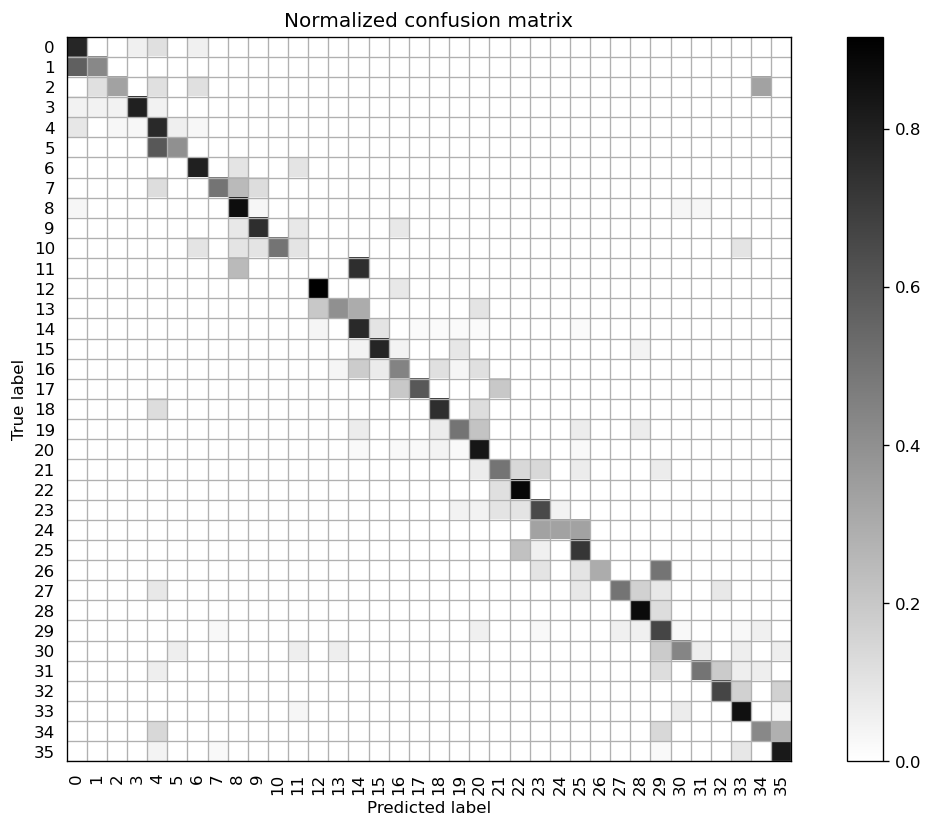

In [52]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13','14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26','27', '28', '29', '30', '31', '32', '33', '34', '35']

y_true = y_test
y_pred = y_predicted

tick_marks = np.array(range(len(labels))) + 0.5

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.binary):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels, rotation=90)
    plt.yticks(xlocations, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_normalized)
plt.figure(figsize=(12, 8), dpi=120)

ind_array = np.arange(len(labels))
x, y = np.meshgrid(ind_array, ind_array)

for x_val, y_val in zip(x.flatten(), y.flatten()):
    c = cm_normalized[y_val][x_val]
    # if c > 0.01:
    #     plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=7, va='center', ha='center')
# offset the tick
plt.gca().set_xticks(tick_marks, minor=True)
plt.gca().set_yticks(tick_marks, minor=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.grid(True, which='minor', linestyle='-')
# plt.gcf().subplots_adjust(bottom=0.15)

plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
# show confusion matrix
plt.savefig('confusion_matrix.png', format='png')
plt.show()

In [63]:
from sklearn.ensemble import RandomForestClassifier

model_fore = RandomForestClassifier()
parameters = {'max_depth':range(3,20,1),'min_samples_leaf':range(2,20,1),'max_features':range(2,30,1)}

In [64]:
# outer loop to find best parameters
model_forest = RandomizedSearchCV(model_fore, parameters, cv=5, n_jobs=-1, random_state=20)
model_forest.fit(predictors_train, y_train.values.ravel())
model_forest.best_params_
# joblib.dump(model_forest, 'Rec.pkl')

{'min_samples_leaf': 8, 'max_features': 22, 'max_depth': 14}

In [65]:
# inner loop to calculate cross validation
cross_val_score(model_forest, predictors_train, y_train.values.ravel(), cv=5, scoring='accuracy')

array([0.66, 0.65, 0.66, 0.67, 0.71])

In [66]:
y_predicted = model_forest.predict(X_test_norm)

print(confusion_matrix(y_test, y_predicted))
print(classification_report(y_test, y_predicted))

[[12  1  0 ...  0  0  0]
 [ 1  6  0 ...  0  0  0]
 [ 0  0  3 ...  0  0  0]
 ...
 [ 0  0  0 ... 24  0  3]
 [ 0  0  0 ...  2  0  3]
 [ 0  0  0 ...  5  0 39]]
              precision    recall  f1-score   support

         0.0       0.80      0.67      0.73        18
         1.0       0.75      0.86      0.80         7
         2.0       0.75      0.33      0.46         9
         3.0       0.71      0.85      0.77        20
         4.0       0.77      0.79      0.78        34
         5.0       0.50      0.40      0.44         5
         6.0       1.00      0.40      0.57        10
         7.0       1.00      0.25      0.40         8
         8.0       0.66      0.83      0.74        30
         9.0       0.73      0.92      0.81        12
        10.0       0.56      0.50      0.53        10
        11.0       0.00      0.00      0.00         4
        12.0       0.91      0.83      0.87        12
        13.0       0.33      0.20      0.25        10
        14.0       0.74      0.84

[[0.67 0.06 0.   ... 0.   0.   0.  ]
 [0.14 0.86 0.   ... 0.   0.   0.  ]
 [0.   0.   0.33 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.86 0.   0.11]
 [0.   0.   0.   ... 0.29 0.   0.43]
 [0.   0.   0.   ... 0.11 0.   0.87]]


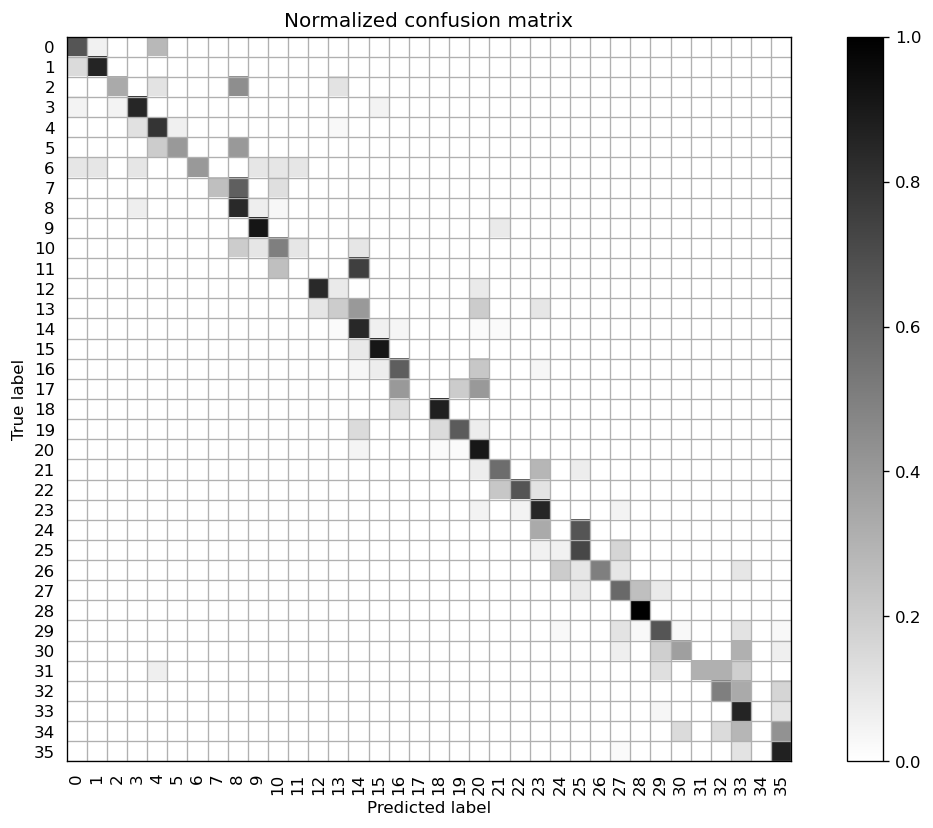

In [67]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13','14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26','27', '28', '29', '30', '31', '32', '33', '34', '35']

y_true = y_test
y_pred = y_predicted

tick_marks = np.array(range(len(labels))) + 0.5

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.binary):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels, rotation=90)
    plt.yticks(xlocations, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_normalized)
plt.figure(figsize=(12, 8), dpi=120)

ind_array = np.arange(len(labels))
x, y = np.meshgrid(ind_array, ind_array)

for x_val, y_val in zip(x.flatten(), y.flatten()):
    c = cm_normalized[y_val][x_val]
    # if c > 0.01:
    #     plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=7, va='center', ha='center')
# offset the tick
plt.gca().set_xticks(tick_marks, minor=True)
plt.gca().set_yticks(tick_marks, minor=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.grid(True, which='minor', linestyle='-')
# plt.gcf().subplots_adjust(bottom=0.15)

plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
# show confusion matrix
plt.savefig('confusion_matrix.png', format='png')
plt.show()

In [39]:
from sklearn.neural_network import MLPClassifier
mlp_param = {'alpha': np.linspace(0.001,0.5,500)}
mlp_classifier = MLPClassifier(solver = 'adam', hidden_layer_sizes=(60,80,200), random_state=20, max_iter=5000,verbose=0)

In [40]:
# outer loop to find best parameters
model_mlp = RandomizedSearchCV(mlp_classifier, mlp_param, cv=3, n_jobs=-1, random_state=20)
model_mlp.fit(predictors_train, y_train.values.ravel())
model_mlp.best_params_

{'alpha': 0.030000000000000002}

In [41]:
# inner loop to calculate cross validation
cross_val_score(model_mlp, predictors_train, y_train.values.ravel(), cv=5, scoring='accuracy')

array([0.73745174, 0.67374517, 0.68339768, 0.72340426, 0.74661509])

In [46]:
y_predicted = model_mlp.predict(X_test_norm)

print(confusion_matrix(y_test, y_predicted))
print(classification_report(y_test, y_predicted))

[[13  0  0 ...  0  0  0]
 [ 1  6  0 ...  0  0  0]
 [ 0  1  4 ...  0  0  0]
 ...
 [ 0  0  0 ... 23  1  1]
 [ 0  0  0 ...  2  2  1]
 [ 0  0  0 ...  5  0 39]]
              precision    recall  f1-score   support

         0.0       0.87      0.72      0.79        18
         1.0       0.75      0.86      0.80         7
         2.0       0.67      0.44      0.53         9
         3.0       0.82      0.90      0.86        20
         4.0       0.84      0.76      0.80        34
         5.0       0.33      0.80      0.47         5
         6.0       0.83      0.50      0.62        10
         7.0       0.67      0.50      0.57         8
         8.0       0.75      0.90      0.82        30
         9.0       1.00      0.75      0.86        12
        10.0       0.64      0.70      0.67        10
        11.0       0.00      0.00      0.00         4
        12.0       0.85      0.92      0.88        12
        13.0       1.00      0.30      0.46        10
        14.0       0.85      0.69

[[0.72 0.   0.   ... 0.   0.   0.  ]
 [0.14 0.86 0.   ... 0.   0.   0.  ]
 [0.   0.11 0.44 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.82 0.04 0.04]
 [0.   0.   0.   ... 0.29 0.29 0.14]
 [0.   0.   0.   ... 0.11 0.   0.87]]


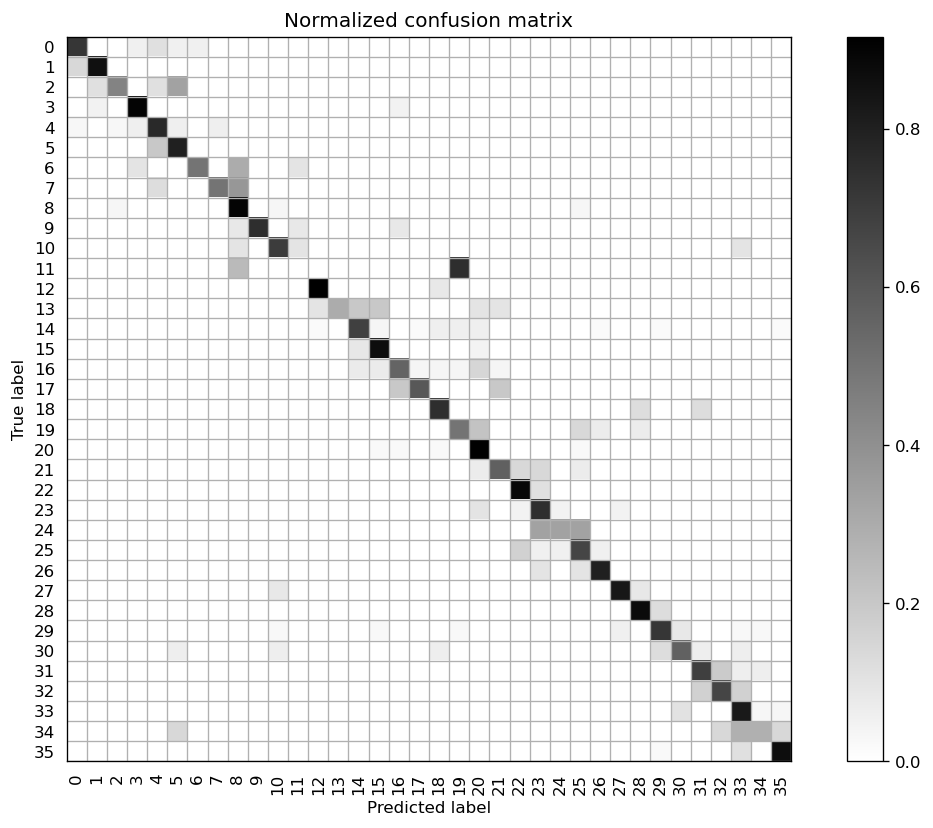

In [53]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13','14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26','27', '28', '29', '30', '31', '32', '33', '34', '35']

y_true = y_test
y_pred = y_predicted

tick_marks = np.array(range(len(labels))) + 0.5

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.binary):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels, rotation=90)
    plt.yticks(xlocations, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_normalized)
plt.figure(figsize=(12, 8), dpi=120)

ind_array = np.arange(len(labels))
x, y = np.meshgrid(ind_array, ind_array)

for x_val, y_val in zip(x.flatten(), y.flatten()):
    c = cm_normalized[y_val][x_val]
    # if c > 0.01:
    #     plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=7, va='center', ha='center')
# offset the tick
plt.gca().set_xticks(tick_marks, minor=True)
plt.gca().set_yticks(tick_marks, minor=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.grid(True, which='minor', linestyle='-')
# plt.gcf().subplots_adjust(bottom=0.15)

plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
# show confusion matrix
plt.savefig('confusion_matrix.png', format='png')
plt.show()

In [54]:
# focal loss with multi label
def focal_loss(classes_num, gamma=2., alpha=.25, e=0.1):
    # classes_num contains sample number of each classes
    def focal_loss_fixed(target_tensor, prediction_tensor):
        '''
        prediction_tensor is the output tensor with shape [None, 100], where 100 is the number of classes
        target_tensor is the label tensor, same shape as predcition_tensor
        '''
        import tensorflow as tf
        from tensorflow.python.ops import array_ops
        from keras import backend as K

        #1# get focal loss with no balanced weight which presented in paper function (4)
        zeros = array_ops.zeros_like(prediction_tensor, dtype=prediction_tensor.dtype)
        one_minus_p = array_ops.where(tf.greater(target_tensor,zeros), target_tensor - prediction_tensor, zeros)
        FT = -1 * (one_minus_p ** gamma) * tf.math.log(tf.clip_by_value(prediction_tensor, 1e-8, 1.0))

        #2# get balanced weight alpha
        classes_weight = array_ops.zeros_like(prediction_tensor, dtype=prediction_tensor.dtype)

        total_num = float(sum(classes_num))
        classes_w_t1 = [ total_num / ff for ff in classes_num ]
        sum_ = sum(classes_w_t1)
        classes_w_t2 = [ ff/sum_ for ff in classes_w_t1 ]   #scale
        classes_w_tensor = tf.convert_to_tensor(classes_w_t2, dtype=prediction_tensor.dtype)
        classes_weight += classes_w_tensor

        alpha = array_ops.where(tf.greater(target_tensor, zeros), classes_weight, zeros)

        #3# get balanced focal loss
        balanced_fl = alpha * FT
        balanced_fl = tf.reduce_mean(balanced_fl)

        #4# add other op to prevent overfit
        # reference : https://spaces.ac.cn/archives/4493
        nb_classes = len(classes_num)
        fianal_loss = (1-e) * balanced_fl + e * K.categorical_crossentropy(K.ones_like(prediction_tensor)/nb_classes, prediction_tensor)

        return fianal_loss
    return focal_loss_fixed

In [55]:
class_num = []
for i in range(len(df['chord'].value_counts())):
    class_num.append(df['chord'].value_counts()[i])

In [56]:
# def focal_loss(y_true, y_pred):
#     gamma = 2
#     alpha = 0.25
#     '''tf.where(tensor,a,b):
#     pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#     pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
#     pt_1 = K.clip(pt_1, 1e-3, .999)
#     pt_0 = K.clip(pt_0, 1e-3, .999)
#     return K.mean(-alpha*K.pow(1.-pt_1, gamma)*K.log(pt_1)-(1-alpha)*K.pow(pt_0, gamma)*K.log(1.-pt_0))

In [72]:
# ANN with focal loss
from keras import regularizers
import tensorflow as tf
from keras.layers import Dense,Dropout


model=tf.keras.models.Sequential()
initializer = tf.keras.initializers.GlorotUniform(seed=0)
model.add(Dense(60,input_dim=7,activation='relu',kernel_initializer=initializer))
model.add(Dense(80,input_dim=60,activation='relu',kernel_initializer=initializer))
model.add(Dense(200,input_dim=80,activation='relu',kernel_initializer=initializer))
model.add(Dense(36,input_dim=200,activation='relu',kernel_initializer=initializer))
model.add(Dense(36,activation='softmax',kernel_initializer=initializer))

# focal_loss[(class)num)]
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
 
model.fit(predictors_train, y_train.values.ravel(),epochs=150, batch_size=16, validation_split=0.1, shuffle=True)
model.save('model.h5')

Epoch 1/150
146/146 [==============================] - 1s 3ms/step - loss: 3.2567 - accuracy: 0.1185 - val_loss: 4.0470 - val_accuracy: 0.0772
Epoch 2/150
146/146 [==============================] - 0s 2ms/step - loss: 2.7338 - accuracy: 0.2207 - val_loss: 3.5114 - val_accuracy: 0.1158
Epoch 3/150
146/146 [==============================] - 0s 2ms/step - loss: 2.4111 - accuracy: 0.2847 - val_loss: 3.3020 - val_accuracy: 0.1236
Epoch 4/150
146/146 [==============================] - 0s 2ms/step - loss: 2.2010 - accuracy: 0.3323 - val_loss: 3.2638 - val_accuracy: 0.1583
Epoch 5/150
146/146 [==============================] - 0s 2ms/step - loss: 2.0552 - accuracy: 0.3727 - val_loss: 3.0646 - val_accuracy: 0.1660
Epoch 6/150
146/146 [==============================] - 0s 2ms/step - loss: 1.9226 - accuracy: 0.4096 - val_loss: 3.0107 - val_accuracy: 0.1660
Epoch 7/150
146/146 [==============================] - 0s 2ms/step - loss: 1.8447 - accuracy: 0.4204 - val_loss: 2.9217 - val_accuracy: 0.1737

In [73]:
y_predicted = model.predict(X_test_norm)
final_predicted = np.argmax(y_predicted, axis=1, out=None)

        
print(confusion_matrix(y_test, final_predicted))
print(classification_report(y_test, final_predicted))
# final_predicted

19/19 [==============================] - 0s 923us/step
[[13  1  1 ...  0  0  0]
 [ 0  6  0 ...  0  0  0]
 [ 0  1  4 ...  0  3  0]
 ...
 [ 0  0  0 ... 23  2  2]
 [ 0  0  0 ...  0  3  1]
 [ 0  0  0 ...  4  0 39]]
              precision    recall  f1-score   support

         0.0       0.87      0.72      0.79        18
         1.0       0.75      0.86      0.80         7
         2.0       0.67      0.44      0.53         9
         3.0       0.89      0.85      0.87        20
         4.0       0.81      0.88      0.85        34
         5.0       0.57      0.80      0.67         5
         6.0       0.64      0.70      0.67        10
         7.0       0.67      0.75      0.71         8
         8.0       0.90      0.90      0.90        30
         9.0       0.82      0.75      0.78        12
        10.0       0.75      0.60      0.67        10
        11.0       0.25      0.25      0.25         4
        12.0       0.77      0.83      0.80        12
        13.0       0.67      0.2

In [74]:
# decoding the final predictions
le1.inverse_transform(final_predicted)

array(['Ao7', 'D7', 'F7', 'Eo7', 'D7', 'F6', 'Eb7', 'G7', 'C7', 'Am7',
       'F7', 'Cm7', 'C', 'C7', 'E7', 'Gm7', 'B7', 'G', 'E7', 'Dm7', 'Db7',
       'Eo7', 'Eo7', 'C7', 'G7', 'Ao7', 'F6', 'A7#5', 'Bb7', 'Bb', 'G6',
       'Bbm7', 'D7b7', 'A7#5', 'Em7', 'Am7', 'E7', 'G7b7', 'Ab7', 'Dm7',
       'Ab7', 'Db7', 'Dm7', 'Am7', 'Gm7', 'Gm7', 'Gm7', 'D7b7', 'G7',
       'F7', 'Bb7', 'G7', 'A7', 'Am7', 'Am7', 'B7', 'B7', 'G7', 'Bb7',
       'Gm7', 'Eb7', 'D7b7', 'Fm7', 'Bb', 'D7', 'Bm7', 'Db', 'Fm7', 'F7',
       'G7', 'Eo7', 'Bb7', 'A7', 'Cm7', 'D7', 'Db7', 'Ab7', 'A7', 'F6',
       'Cm7', 'F7', 'Gm7', 'Cm7', 'F7', 'Eb7', 'Am7', 'Am7', 'Gm7', 'Gm7',
       'Bb7', 'C', 'Bb7', 'G7b7', 'G7b7', 'Dm7', 'Eb7', 'Bbm7', 'A7#5',
       'G', 'F7', 'E7', 'D7', 'Ab', 'Gm7', 'Am7', 'Bb', 'Gm7', 'Bb7',
       'Dm7', 'Cm7', 'Bb7', 'G6', 'Em7', 'Cm7', 'Bb7', 'G6', 'Gm7', 'Ab7',
       'A7', 'G6', 'C7', 'Am7', 'Bb7', 'Eb7', 'Gm7', 'Fm7', 'Cm7', 'Ab7',
       'C7', 'Gm7', 'G7', 'Bbm7', 'Am7', 'Ab7', 'Ab7', 

In [75]:
# le2.inverse_transform(np.round(X_test.iloc[:,0]).astype(int))

[[0.72 0.06 0.06 ... 0.   0.   0.  ]
 [0.   0.86 0.   ... 0.   0.   0.  ]
 [0.   0.11 0.44 ... 0.   0.33 0.  ]
 ...
 [0.   0.   0.   ... 0.82 0.07 0.07]
 [0.   0.   0.   ... 0.   0.43 0.14]
 [0.   0.   0.   ... 0.09 0.   0.87]]


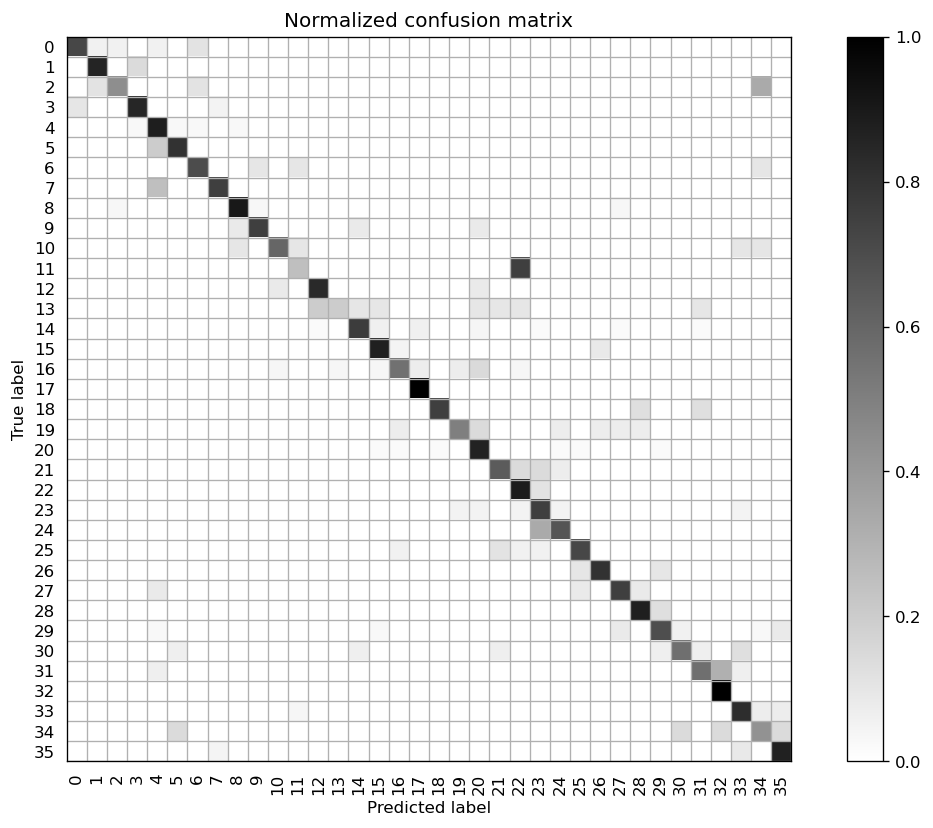

In [77]:
# confusion matrix for ann
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13','14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26','27', '28', '29', '30', '31', '32', '33', '34', '35']

y_true = y_test
y_pred = final_predicted

tick_marks = np.array(range(len(labels))) + 0.5

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.binary):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels, rotation=90)
    plt.yticks(xlocations, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_normalized)
plt.figure(figsize=(12, 8), dpi=120)

ind_array = np.arange(len(labels))
x, y = np.meshgrid(ind_array, ind_array)

for x_val, y_val in zip(x.flatten(), y.flatten()):
    c = cm_normalized[y_val][x_val]
    # if c > 0.01:
    #     plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=7, va='center', ha='center')
# offset the tick
plt.gca().set_xticks(tick_marks, minor=True)
plt.gca().set_yticks(tick_marks, minor=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.grid(True, which='minor', linestyle='-')
# plt.gcf().subplots_adjust(bottom=0.15)

plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
# show confusion matrix
plt.savefig('confusion_matrix.png', format='png')
plt.show()

In [78]:
# decoding the notes
def changeNumber(o):
    dict = {
        1:'C',
        2:'D',
        3:'E',
        4:'F',
        5:'G',
        6:'A',
        0:'B'}
    return dict.get(o)

In [79]:
changeNumber(round(np.array(X_test)[0][2])%7)

'E'

In [80]:
# chck all clsses
a = []
for i in range(36):
    a.append(i)
a = le1.inverse_transform(a)
a

array(['A7', 'A7#5', 'Ab', 'Ab7', 'Am7', 'Ao7', 'B7', 'Bb', 'Bb7', 'Bbm7',
       'Bm7', 'Bo7', 'C', 'C6', 'C7', 'Cm7', 'D7', 'D7b7', 'Db', 'Db7',
       'Dm7', 'E7', 'Eb', 'Eb7', 'Ebm7', 'Em7', 'Eo7', 'F', 'F6', 'F7',
       'Fm7', 'G', 'G6', 'G7', 'G7b7', 'Gm7'], dtype=object)

In [81]:
X_test

,keySignature,note1,note2,note3,note4,note5,note6
2964,7.0,19.51,23.51,26.00,30.000000,28.170000,29.666667
667,9.0,13.00,20.00,22.00,24.000000,26.170000,29.333333
2199,2.0,17.00,20.00,23.00,25.000000,28.666667,29.503333
101,8.0,17.00,20.51,23.00,26.000000,28.333333,29.503333
842,9.0,16.00,20.00,22.00,25.490000,26.170000,29.333333
...,...,...,...,...,...,...,...
1687,1.0,21.00,25.00,26.51,32.000000,29.000000,31.503333
1853,8.0,12.00,16.00,19.00,23.000000,26.000000,27.503333
105,8.0,12.51,18.51,22.00,24.503333,27.000000,27.000000
2467,1.0,16.00,19.51,22.00,25.000000,26.000000,27.000000


In [82]:
# decode the softmax result
qc = np.array(X_test)
finla_predicted = []
for i in range(len(qc)):
    mychord = set()
    for n in range(1,5):
        note = changeNumber(round(qc[i][n]) % 7)
        mychord.add(note)
    mychord = list(mychord)
    
    backup = []
    for j in range(36):
        for n in range(len(mychord)):
            if mychord[n] in a[j]:
                backup.append(j)
    # print(backup)
    predicted = []
    for j in backup:
        predicted.append(y_predicted[i][j])
    
    finla_predicted.append(backup[np.argmax(predicted)])
    # print(backup[np.argmax(predicted)])

In [96]:
print(confusion_matrix(y_test, final_predicted))
print(classification_report(y_test, final_predicted))

[[13  1  1 ...  0  0  0]
 [ 0  6  0 ...  0  0  0]
 [ 0  1  4 ...  0  3  0]
 ...
 [ 0  0  0 ... 23  2  2]
 [ 0  0  0 ...  0  3  1]
 [ 0  0  0 ...  4  0 39]]
              precision    recall  f1-score   support

         0.0       0.87      0.72      0.79        18
         1.0       0.75      0.86      0.80         7
         2.0       0.67      0.44      0.53         9
         3.0       0.89      0.85      0.87        20
         4.0       0.81      0.88      0.85        34
         5.0       0.57      0.80      0.67         5
         6.0       0.64      0.70      0.67        10
         7.0       0.67      0.75      0.71         8
         8.0       0.90      0.90      0.90        30
         9.0       0.82      0.75      0.78        12
        10.0       0.75      0.60      0.67        10
        11.0       0.25      0.25      0.25         4
        12.0       0.77      0.83      0.80        12
        13.0       0.67      0.20      0.31        10
        14.0       0.93      0.76

In [97]:
# ambiguyity mechanism
level = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
qc1 = []
qc2 = []
qc3 = []
qc4 = [] # index of ambiguity data
for l in level:
    count = 0
    fail = 0
    temp = []
    for i in range(len(y_predicted)):
        output = max(y_predicted[i])
        if output < l:
            # print(output)
            count += 1
            if np.argmax(y_predicted[i]) != np.array(y_test)[i]:
                fail += 1
            temp.append(i)
    qc1.append(count)
    qc2.append(fail/count)
    qc3.append(1-(152-fail)/(608-count))
    qc4.append(temp)

print(count) # represents the number of data less than a certain confidence, which are defined as ambiguity
print(count/608) # represents the percentage of ambiguity data in the dataset
print(fail/count) # represents the percentage of the fail 
print(1-(152-fail)/(608-count)) # represents the accuracy without the ambiguity data

226
0.3717105263157895
0.48672566371681414
0.8900523560209423


In [98]:
qc = pd.DataFrame([qc1,qc2,qc3],columns=level,index=['number of ambiguity','percentage of fails in ambiguity', 'accuracy without ambiguity'])
qc

,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
number of ambiguity,23.000000,38.000000,49.000000,64.000000,85.000000,102.000000,122.000000,145.000000,181.000000,226.000000
percentage of fails in ambiguity,0.869565,0.815789,0.755102,0.765625,0.717647,0.647059,0.598361,0.572414,0.535912,0.486726
accuracy without ambiguity,0.774359,0.787719,0.794275,0.810662,0.826004,0.830040,0.837449,0.850972,0.871194,0.890052


In [99]:
y_predicted[1].argsort()[-4:][::-1]

array([16, 17, 28, 20], dtype=int64)

In [100]:
# high frequency chord under each key signatrure
def changeKey(o):
    dict = {
        'CM':[14, 20, 33, 4, 29, 25, 27, 12, 31, 13, 28, 32],
        'EM':[0, 21, 6, 1],
        'GM':[14, 33, 4, 16, 25, 12, 9, 31, 13, 17, 34, 32],
        'AM':[16, 0, 21, 9, 1, 17],
        'BM':[21, 6],
        'DM':[33, 16, 0, 25, 9, 31, 1, 17, 34, 32],
        'FM':[14, 20, 35, 4, 8, 29, 27, 12, 13, 28, 26, 7],
        'AbM':[23, 15, 3, 19, 9, 30, 22, 2],
        'BbM':[20, 35, 8, 29, 15, 27, 28, 7, 5],
        'DbM':[3, 19, 9, 30, 24, 2, 18],
        'EbM':[35, 8, 23, 15, 3, 30, 22, 7, 2],
    }
    return dict.get(o)

In [101]:
np.array(X_test)[19]

array([ 3.  , 16.  , 20.  , 22.  , 25.  , 28.17, 29.33])

In [102]:
# check accuracy under different thresholds
correct = []
for l in range(len(level)):
    count = 0
    for i in range(len(y_predicted)):
        if i in qc4[l]:
            ambiguity = y_predicted[i].argsort()[-4:][::-1]
            key = le2.inverse_transform([int(np.array(X_test)[i][0])])[0]
            key_chord = changeKey(key)
            for j in range(len(ambiguity[1:])):
                if ambiguity[1:][j] in key_chord:
                    ambiguity = np.insert(ambiguity, 1, ambiguity[1:][j])
                    ambiguity = np.delete(ambiguity, j+2)
            # print(ambiguity)
            if np.array(y_test)[i] in ambiguity:
                count += 1
        elif np.array(y_test)[i] == np.argmax(y_predicted[i]):
            count += 1
        
    correct.append(count/606)
correct

[0.768976897689769,
 0.7772277227722773,
 0.7838283828382838,
 0.7937293729372937,
 0.8036303630363036,
 0.8085808580858086,
 0.8135313531353136,
 0.8250825082508251,
 0.8399339933993399,
 0.8481848184818482]

In [103]:
le2.inverse_transform([int(np.array(X_test)[473][0])])[0]

'BbM'

In [104]:
le1.inverse_transform([22])

array(['Eb'], dtype=object)

In [108]:
# use the ambiguity mechanism to change prediction
ambiguity_predicted = final_predicted
for l in range(len(level)):
    ambiguity_predicted = final_predicted
    for i in range(len(y_predicted)):
        if i in qc4[l]:
            ambiguity = y_predicted[i].argsort()[-4:][::-1]
            key = le2.inverse_transform([int(np.array(X_test)[i][0])])[0]
            key_chord = changeKey(key)
            for j in range(len(ambiguity[1:])):
                if ambiguity[1:][j] in key_chord:
                    ambiguity = np.insert(ambiguity, 1, ambiguity[1:][j])
                    ambiguity = np.delete(ambiguity, j+2)
            # print(ambiguity)
            if np.array(y_test)[i] in ambiguity:
                ambiguity_predicted[i] = np.array(y_test)[i]
        elif np.array(y_test)[i] == np.argmax(y_predicted[i]):
            pass

In [109]:
print(confusion_matrix(y_test, ambiguity_predicted))
print(classification_report(y_test, ambiguity_predicted))

[[16  0  1 ...  0  0  0]
 [ 0  7  0 ...  0  0  0]
 [ 0  1  4 ...  0  3  0]
 ...
 [ 0  0  0 ... 26  0  1]
 [ 0  0  0 ...  0  6  0]
 [ 0  0  0 ...  3  0 40]]
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89        18
         1.0       0.88      1.00      0.93         7
         2.0       0.67      0.44      0.53         9
         3.0       1.00      0.85      0.92        20
         4.0       0.84      0.94      0.89        34
         5.0       0.67      0.80      0.73         5
         6.0       0.82      0.90      0.86        10
         7.0       0.67      0.75      0.71         8
         8.0       0.93      0.90      0.92        30
         9.0       0.91      0.83      0.87        12
        10.0       0.86      0.60      0.71        10
        11.0       0.25      0.25      0.25         4
        12.0       0.79      0.92      0.85        12
        13.0       1.00      0.50      0.67        10
        14.0       0.96      0.92

[[0.89 0.   0.06 ... 0.   0.   0.  ]
 [0.   1.   0.   ... 0.   0.   0.  ]
 [0.   0.11 0.44 ... 0.   0.33 0.  ]
 ...
 [0.   0.   0.   ... 0.93 0.   0.04]
 [0.   0.   0.   ... 0.   0.86 0.  ]
 [0.   0.   0.   ... 0.07 0.   0.89]]


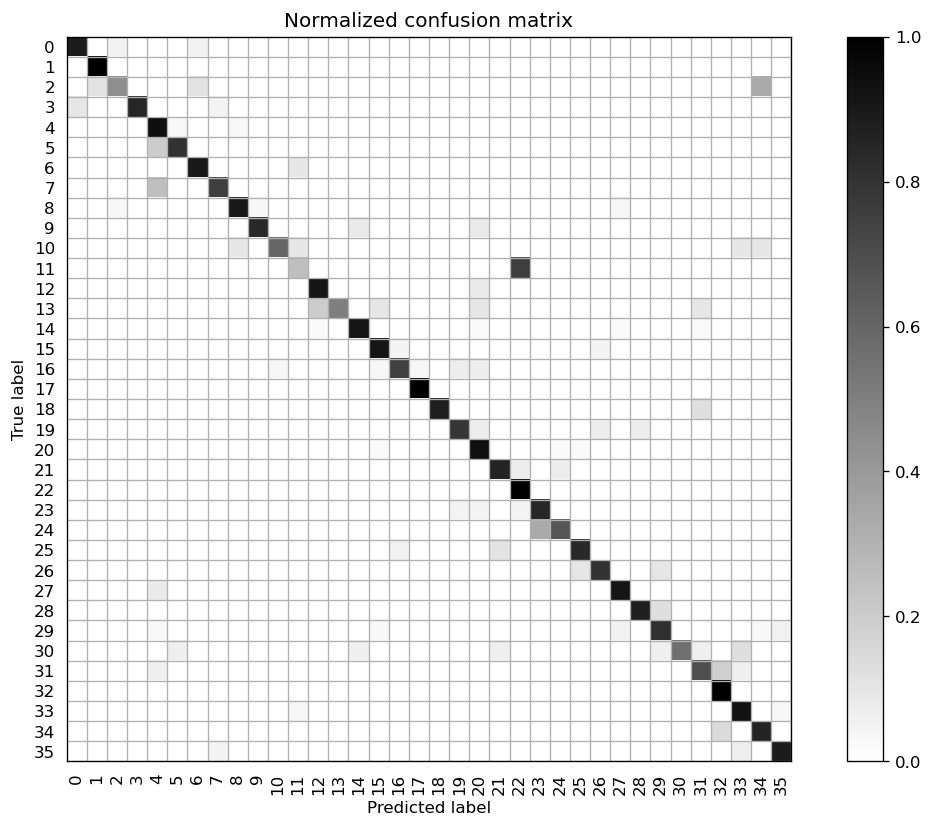

In [111]:
# final confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13','14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26','27', '28', '29', '30', '31', '32', '33', '34', '35']

y_true = y_test
y_pred = ambiguity_predicted

tick_marks = np.array(range(len(labels))) + 0.5

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.binary):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels, rotation=90)
    plt.yticks(xlocations, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_normalized)
plt.figure(figsize=(12, 8), dpi=120)

ind_array = np.arange(len(labels))
x, y = np.meshgrid(ind_array, ind_array)

for x_val, y_val in zip(x.flatten(), y.flatten()):
    c = cm_normalized[y_val][x_val]
    # if c > 0.01:
    #     plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=7, va='center', ha='center')
# offset the tick
plt.gca().set_xticks(tick_marks, minor=True)
plt.gca().set_yticks(tick_marks, minor=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.grid(True, which='minor', linestyle='-')
# plt.gcf().subplots_adjust(bottom=0.15)

plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
# show confusion matrix
plt.savefig('confusion_matrix.png', format='png')
plt.show()